In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
# from lesson_functions import *
%matplotlib inline
# from features import *
# from parameters import *
# from windows import *

In [3]:
vehicle_images_gti_far=glob.glob('vehicles/GTI_Far/image*.png')
vehicle_images_gti_left=glob.glob('vehicles/GTI_Left/image*.png')
vehicle_images_gti_right=glob.glob('vehicles/GTI_Right/image*.png')
vehicle_images_kitti=glob.glob('vehicles/KITTI_extracted/*.png')
vehicle_images_middle=glob.glob('vehicles/GTI_MiddleClose/image*.png')

In [4]:
cars=vehicle_images_gti_far+vehicle_images_gti_left+vehicle_images_gti_right+vehicle_images_kitti+vehicle_images_middle

In [5]:
non_vehicle_images_extras=glob.glob('non-vehicles/Extras/extra*.png')
non_vehicle_images_gti=glob.glob('non-vehicles/GTI/*.png')

In [6]:
notcars=non_vehicle_images_extras+non_vehicle_images_gti

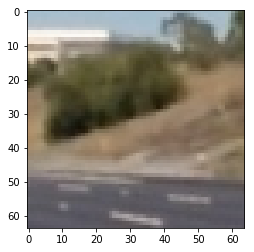

In [9]:
car_image=mpimg.imread(cars[310])
non_car_image=mpimg.imread(notcars[300])
plt.imshow(non_car_image)

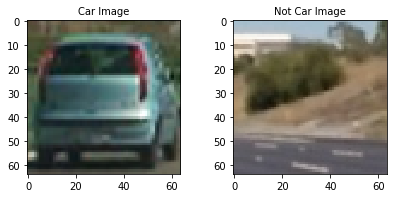

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(non_car_image)
ax2.set_title('Not Car Image', fontsize=10)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.)
f.savefig('output_images/car_notcar.png')

# Extraction of different features

In [60]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.concatenate((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
#         image=image.astype(np.float32)/255
#         image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
#         print(bbox)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Hardcoded Parameters

In [37]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 30  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
n_frames=30
aspect_min,aspect_max = 0.7,3
min_bbox_area=40*40
min_close_area=80*80
close_y=500

# Window search on single_image features

In [77]:
def single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)[0])
                hog_image=get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)[1]
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features),hog_image

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 1), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features ,hog_image= single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            plt.imshow(hog_image)
            plt.show()
            cv2.imwrite('output_images/HOG_example.png',hog_image)
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time


# Training SVM 

In [44]:
sample_size = 'ALL'
if sample_size!='ALL':
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

# color_space2 ='HSV'

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# car_features2= extract_features(cars,color_space=color_space2,spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
#                               cell_per_block=cell_per_block,hog_channel=hog_channel,spatial_feat=True,hist_feat=True,hog_feat=False)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features,notcar_features,notcar_features,notcar_features,notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(4*len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# # svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()



/Users/samkitjain/anaconda/envs/python35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 30 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3240


In [47]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


KeyboardInterrupt: 

In [48]:
import pickle
filename = 'final_model.sav'
svc = pickle.load(open(filename, 'rb'))

In [49]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [122]:
import pickle
filename = 'final_model.sav'
pickle.dump(svc, open(filename, 'wb'))

# Testing on test_images

In [50]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 30  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
n_frames=30
aspect_min,aspect_max = 0.7,3
min_bbox_area=50*50
min_close_area=80*80
close_y=500
close_x_thresh=450

In [51]:
test_images=glob.glob('test_images/test*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

52


/Users/samkitjain/anaconda/envs/python35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


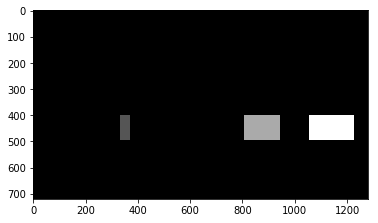

52


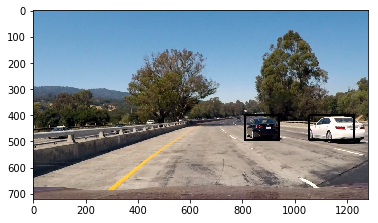

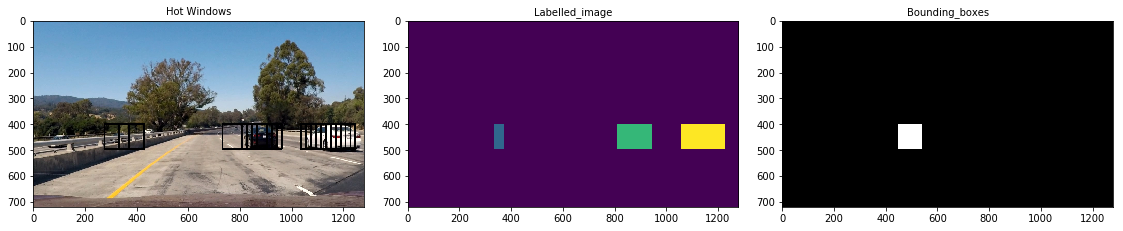

52


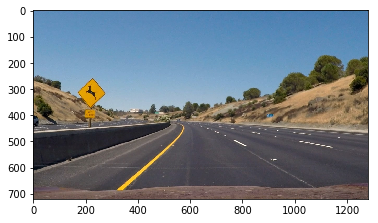

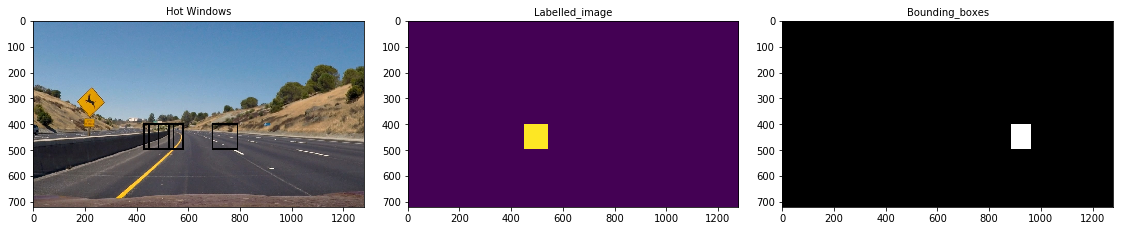

52


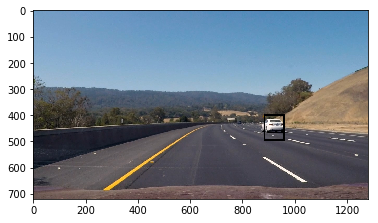

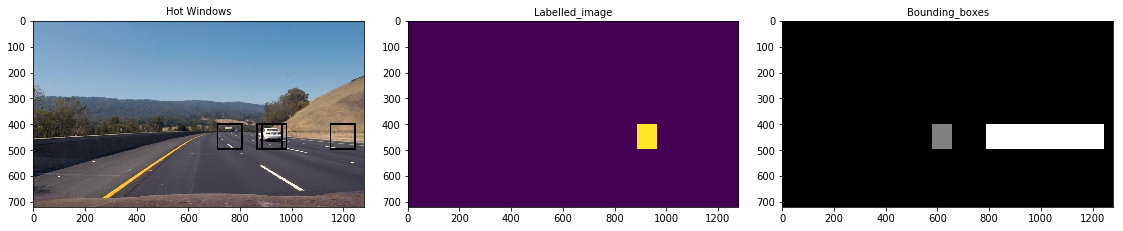

52


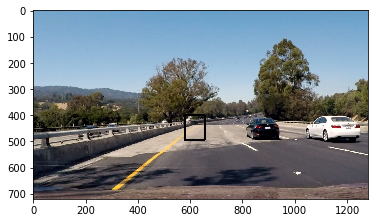

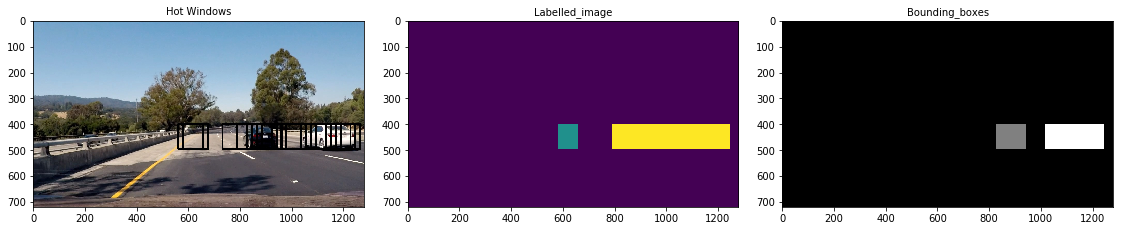

52


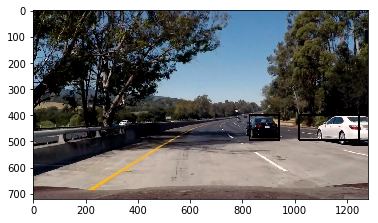

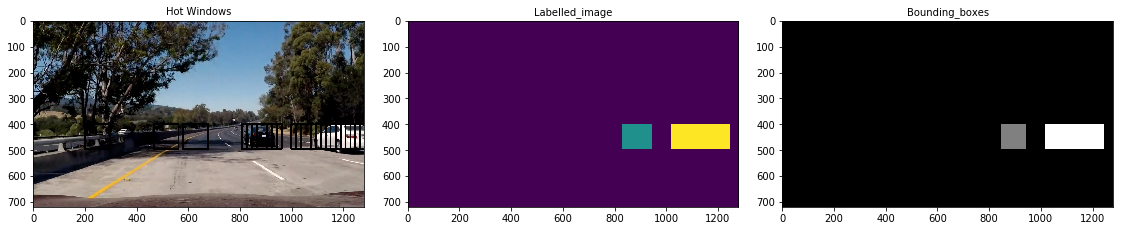

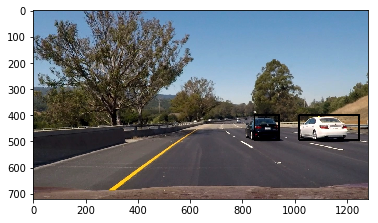

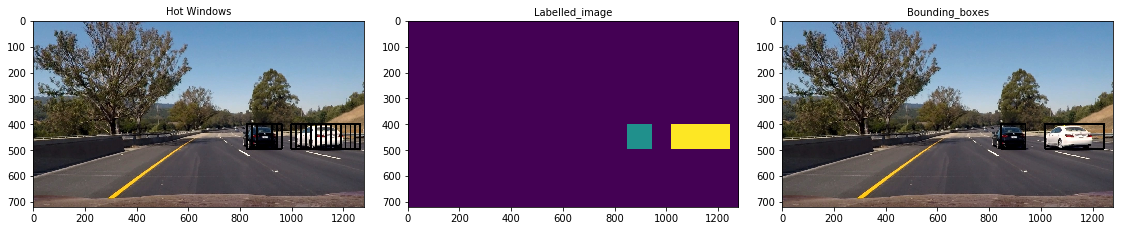

In [66]:
for images in test_images:
    
    image = cv2.imread(images)
    image=cv2.resize(image,(1280,720))
    image = image.astype(np.float32)/255
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    draw_image1 = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows_small = slide_window(image, x_start_stop=[200, 1280], y_start_stop=[400,500], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    windows_medium = slide_window(image,x_start_stop=[0,1280],y_start_stop=[350,550],
                                  xy_window=(128,128),xy_overlap=(0.7,0.7))
    # windows_small_small=slide_window(image,x_start_stop=[200,1280],y_start_stop=[300,680],xy_window=(32,32),xy_overlap=(0.2,0.2))
    # windows_medium = slide_window(image,x_start_stop=[200,1280],y_start_stop=[200,680],xy_window=(128,128),xy_overlap=(0.5,0.5))
    # windows_large = slide_window(image,x_start_stop=[200,1280],y_start_stop=[400,680],xy_window=(200,200),xy_overlap=(0.6,0.6))

    windows=windows_small
    print(len(windows_small))
    # print(len(windows_medium))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)   
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat=np.zeros_like(image[:,:,0]).astype(np.float)
    heat_image=add_heat(heat,hot_windows)
    heat_image_thresh=apply_threshold(heat_image,2)
    heatmap=np.clip(heat_image,0,255)

    labels=label(heatmap)
    plt.imshow(labels[0],cmap='gray')
    plt.show()
    result=draw_labeled_bboxes(draw_image,labels)
    plt.imshow(result)
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 15))
    f.tight_layout()
    ax1.imshow(window_img)
    ax1.set_title('Hot Windows', fontsize=10)
    ax2.imshow(labels[0])
    ax2.set_title('Labelled_image', fontsize=10)
    ax3.imshow(result)
    ax3.set_title('Bounding_boxes', fontsize=10)
    plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.)
    f.savefig('output_images/'+images.split("/")[-1])

52


/Users/samkitjain/anaconda/envs/python35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


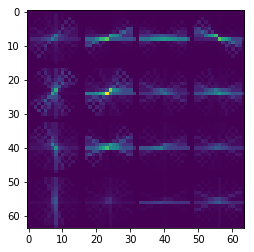

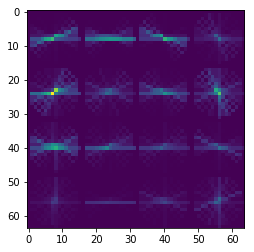

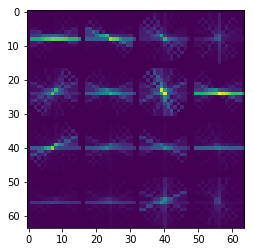

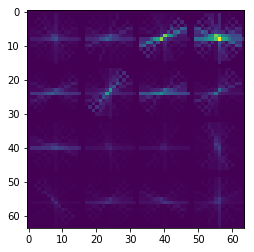

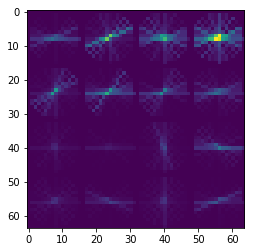

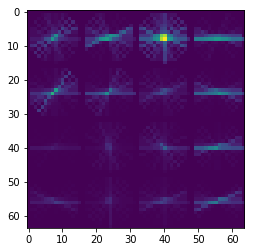

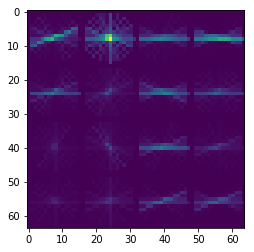

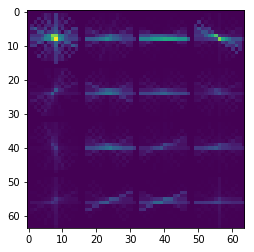

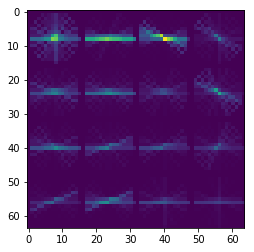

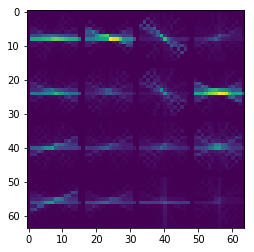

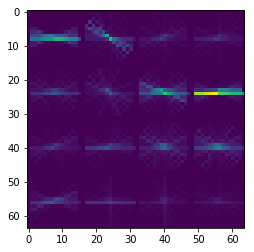

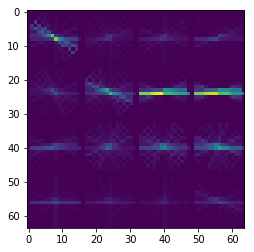

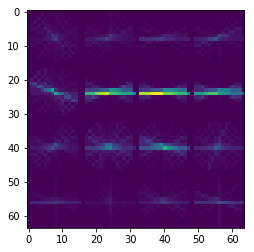

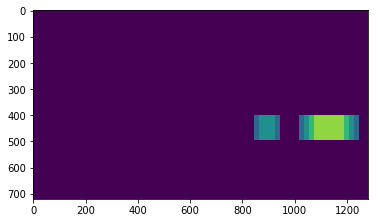

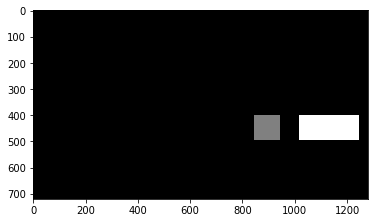

13


True

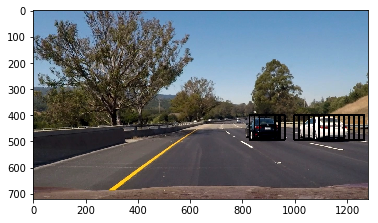

In [78]:

image = cv2.imread('test_images/test6.jpg')
image=cv2.resize(image,(1280,720))
image = image.astype(np.float32)/255
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows_small = slide_window(image, x_start_stop=[200, 1280], y_start_stop=[400,500], 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))

windows_medium = slide_window(image,x_start_stop=[0,1280],y_start_stop=[350,550],
                              xy_window=(128,128),xy_overlap=(0.7,0.7))
# windows_small_small=slide_window(image,x_start_stop=[200,1280],y_start_stop=[300,680],xy_window=(32,32),xy_overlap=(0.2,0.2))
# windows_medium = slide_window(image,x_start_stop=[200,1280],y_start_stop=[200,680],xy_window=(128,128),xy_overlap=(0.5,0.5))
# windows_large = slide_window(image,x_start_stop=[200,1280],y_start_stop=[400,680],xy_window=(200,200),xy_overlap=(0.6,0.6))

windows=windows_small
print(len(windows_small))
# print(len(windows_medium))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

heat=np.zeros_like(image[:,:,0]).astype(np.float)
heat_image=add_heat(heat,hot_windows)
heat_image_thresh=apply_threshold(heat_image,2)
plt.imshow(heat_image)
plt.show()
heatmap=np.clip(heat_image,0,255)
    
labels=label(heatmap)
plt.imshow(labels[0],cmap='gray')
plt.show()
cv2.imwrite('output_images/labels_map.png',labels[0])
result=draw_labeled_bboxes(draw_image,labels)
plt.imshow(result)
cv2.imwrite('output_images/output_bboxes.png',result)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
print(len(hot_windows))
plt.imshow(window_img)
cv2.imwrite('output_images/bboxes.png',window_img)

In [23]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Detection for Videos

In [53]:
class Hot_window():
    def __init__(self,n):
#         print('a')
        self.n=n
        self.windows=[]
    
    def add_windows(self,new_windows):
        self.windows.append(new_windows)
        q_full=len(self.windows)>=self.n
        if q_full:
            _ = self.windows.pop(0)
    
    def get_windows(self):
        output_windows=[]
        
        for window in self.windows:
            output_windows.append(window)
        return output_windows

# Heat map generation

In [54]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
#         print(box)
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]]+=1
    return heatmap

def apply_threshold(heatmap,threshold):
    heatmap[heatmap<threshold]=0
    return heatmap

def find_cars(img,xstart,xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, cells_jump,spatial_size, hist_bins,spatial_feat,hist_feat):
    
    global count
    if count==0:
        print(img.shape)
    
    if (img.shape!=(1280,720)):
        img=cv2.resize(img,(1280,720))
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     nblocks_per_window_copy=int(nblocks_per_window)
    if count==0:
        count=count+1
        print(nblocks_per_window)
#         print(nbocks_per_window_copy)
        print(count)
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_jump
    nysteps = (nyblocks - nblocks_per_window) // cells_jump
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox=[]
    for xb in range(np.int(nxsteps)):
        for yb in range(np.int(nysteps)):
            ypos = yb*cells_jump
            xpos = xb*cells_jump
            # Extract HOG for this patch
            hog_feat1 = hog1[np.int(ypos):int(ypos+nblocks_per_window), int(xpos):int(xpos+nblocks_per_window)].ravel() 
            hog_feat2 = hog2[np.int(ypos):int(ypos+nblocks_per_window), int(xpos):int(xpos+nblocks_per_window)].ravel() 
            hog_feat3 = hog3[np.int(ypos):int(ypos+nblocks_per_window), int(xpos):int(xpos+nblocks_per_window)].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[int(ytop):int(ytop+window), int(xleft):int(xleft+window)], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
#             print(test_prediction)
            if test_prediction==1:
#                 print(test_prediction)
                xbox_left=np.int(xleft*scale)
                ybox_top=np.int(ytop*scale)
                win_draw=np.int(window*scale)
                bbox.append(((int(xbox_left+xstart),int(ybox_top+ystart)),(int(xbox_left+win_draw+xstart),int(ybox_top+win_draw+ystart))))
    
    return bbox

def draw_labeled_bboxes(img,labels):
    for car_number in range(1,labels[1]+1):
        nonzero=(labels[0]==car_number).nonzero()
        
        nonzeroy=np.array(nonzero[0])
        nonzerox=np.array(nonzero[1])
        
        bbox=((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        bbox_w=(bbox[1][0]-bbox[0][0])
        bbox_h=(bbox[1][1]-bbox[0][1])
        
        aspect_ratio=bbox_w/bbox_h
        
        bbox_area=bbox_w*bbox_h
        if bbox_area<min_close_area and bbox[0][1]>close_y:
            small_box_close=True
        else:
            small_box_close=False
            
        if bbox[0][0]<close_x_thresh:
            close_x=True
        else: close_x=False
        
#         cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
        if aspect_ratio>aspect_min and aspect_ratio<aspect_max and not small_box_close and bbox_area>min_bbox_area and not close_x:
#             print("Got a frame")
            cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
#             plt.imshow(img)
#             plt.show()
    return img

In [56]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 30  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
n_frames=30
aspect_min,aspect_max = 0.7,3
min_bbox_area=50*50
min_close_area=80*80
close_y=500
close_x_thresh=430

In [60]:
def pipeline(image):
    global hot_window
    draw_image=np.copy(image)
    image=image.astype(np.float32)/255
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#     hot_window.add_windows(image)
#     if(len(hot_window.windows)<n_frames):
#         return draw_image
    
    windows_small = slide_window(image, x_start_stop=[100,1280], y_start_stop=[400,550], 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
#     windows_medium = slide_window(image,x_start_stop=[200,1280],y_start_stop=[350,550],
#                               xy_window=(128,128),xy_overlap=(0.7,0.7))
    windows=windows_small
    
#     hot_windows=[]
    frames=hot_window.get_windows()
    if len(frames)<n_frames-1:
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
#         print("a")
        
#         hot_windows.append(find_cars(image,400,1280,400, 600, 1.5, svc, X_scaler, orient, pix_per_cell,
#                                      cell_per_block,2,spatial_size, hist_bins,False,True))
#         hot_windows.append(find_cars(image,400,1280,350,600, 2, svc, X_scaler, orient, pix_per_cell,
#                                       cell_per_block,2,spatial_size, hist_bins,False,True))
#         print(len(hot_windows[0]))
        if(len(hot_windows)>0):
#             print('a')
            hot_window.add_windows(hot_windows)
    
        return image
    
    else:
        hot_windows=search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
#         print("b")
        
#         hot_windows.append(find_cars(image,400,1280,400, 550, 1.5, svc, X_scaler, orient, pix_per_cell,
#                                      cell_per_block,2, spatial_size, hist_bins,spatial_feat=False,hist_feat=True))
#         hot_windows.append(find_cars(image,400,1280,350, 550, 2, svc, X_scaler, orient, pix_per_cell,
#                                       cell_per_block,2,spatial_size, hist_bins,spatial_feat=False,hist_feat=True))
#         hot_window.add_windows(np.concatenate(hot_windows))

        if(len(hot_windows)>0):
            hot_window.add_windows(hot_windows)
#         hot_window.add_windows(hot_windows)
            
    hot_windows=hot_window.get_windows()
#     print(len(hot_windows))
        
        
#     hot_windows=[]
#     for frame in frames:
#         hot_windows.append(find_cars(frame,400,1280,350, 550, 1, svc, X_scaler, orient, pix_per_cell,
#                                      cell_per_block, spatial_size, hist_bins,hist_feat,spatial_feat,window=100))
        
#         hot_windows.append(find_cars(frame,400, 600, 1, svc, X_scaler, orient, pix_per_cell,
#                                      cell_per_block, spatial_size, hist_bins))
#         hot_windows.append(search_windows(frame,windows,svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat))
    
    heat=np.zeros_like(image[:,:,0]).astype(np.float)
#     print(hot_windows[0])
#     empty_indices=[]
#     for i in range(len(hot_windows)):
#         if len(hot_windows[i])==0:
#             empty_indices.append(i)
    
#     if(len(empty_indices)>0):
#         for i in empty_indices:
#             print(i)
#             del hot_windows[i]
            
    hot_windows=np.concatenate(hot_windows)
#     print(hot_windows)
    heat_image=add_heat(heat,hot_windows)
    heat_image_thresh=apply_threshold(heat_image,33)
    heatmap=np.clip(heat_image,0,255)
    
    labels=label(heatmap)
#     plt.imshow(labels[0],cmap='gray')
#     plt.show()
    result=draw_labeled_bboxes(draw_image,labels)
#     plt.imshow(result)
#     plt.show()
    return result

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
count=0
hot_window=Hot_window(30)
video_output = 'result_videos/project_output3.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_videos/project_output3.mp4
[MoviePy] Writing video result_videos/project_output3.mp4



 24%|██▍       | 303/1261 [02:15<06:33,  2.43it/s]


 48%|████▊     | 605/1261 [04:16<04:14,  2.57it/s]


 72%|███████▏  | 907/1261 [06:18<02:20,  2.52it/s]


 96%|█████████▌| 1205/1261 [08:25<00:26,  2.15it/s]


100%|█████████▉| 1260/1261 [08:50<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/project_output3.mp4 

CPU times: user 8min 15s, sys: 24.9 s, total: 8min 40s
Wall time: 8min 52s
